# LSTM Siamese neural network

In [35]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
from copy import deepcopy
from torchmetrics import Accuracy

In [79]:
# 设置打印函数
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + '\n' + "%s"%nowtime)
    print(str(info)+"\n")

In [37]:
# 下载 MNIST 数据集并初始化 dataloader
transform = transforms.Compose([transforms.ToTensor()])
ds_train = tv.datasets.MNIST(root="dataset/", train=True, download=True, transform=transform) 
ds_val = tv.datasets.MNIST(root="dataset/", train=False, download=True, transform=transform) 
train_ldr = torch.utils.data.DataLoader(ds_train, batch_size=50, shuffle=True, num_workers=2) 
evaluate_ldr = torch.utils.data.DataLoader(ds_val, batch_size=50, shuffle=False, num_workers=2) 

In [38]:
class LSTM(nn.Module):
    '''
    input_len: 是指MNIST图像的尺寸，本例中为28, 因为每个图像都是 28 x 28 尺寸;
    ''' 
    def __init__(self, input_len, hidden_size, num_classes, n_layers): 
        super(LSTM, self).__init__() 
        self.hidden_size = hidden_size  
        self.n_layers = n_layers        
        # number of layers 可使模型捕捉到不同层次的抽象概念
        self.lstm = nn.LSTM(input_len, hidden_size, n_layers, batch_first=True)  
        # 最后通过线性层输出
        self.output_layer = nn.Linear(hidden_size, num_classes) 
        
   
    def forward(self, X): 
        hidden_states = torch.zeros(self.n_layers, X.size(0), self.hidden_size) 
        cell_states = torch.zeros(self.n_layers, X.size(0), self.hidden_size) 
        output, hide = self.lstm(X, (hidden_states, cell_states)) 
        output = self.output_layer(output[:,-1,:]) 
        
        return output

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_len, hidden_size, num_classes, n_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_len, hidden_size, n_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        # 动态生成隐藏状态和细胞状态
        batch_size = X.size(0)
        hidden_states = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)
        cell_states = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)
        
        # 通过forward方法传入数据和动态生成的隐藏状态和细胞状态
        output, (hide, cell) = self.lstm(X, (hidden_states, cell_states))
        output = self.output_layer(output[:, -1, :])
        return output

In [59]:
# 初始化 LSTM 模型
lstm_class_model = LSTM(28, 128, 10, 3)

In [60]:
# 训练模型
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()  
opt = torch.optim.Adam(lstm_class_model.parameters(), lr=learning_rate)

In [61]:
# 声明device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
lstm_class_model.to(device)
loss_fn.to(device)

CrossEntropyLoss()

In [62]:
# random seeding
np.random.seed(1)  
torch.manual_seed(1)
print("\nLoading 60000 item training dataset")
print("\nCreating LSTM classification network")
print(lstm_class_model)

max_epoch = 50
arraylosses = []  

print("loss = Cross Entropy Loss")
print("optimizer = Adam")
print("maximum epochs = %3d " % max_epoch)
print("learning rate = %0.3f " % learning_rate)
print("\nStarting training")
lstm_class_model.train()  

for epoch in range(0, max_epoch):
    printlog('Epoch {0} / {1}'.format(epoch, max_epoch))
    ep_loss = 0
    loop = tqdm(enumerate(train_ldr), total=len(train_ldr), ncols=100)
    # for batch, (image, label) in enumerate(train_ldr):
    for i, batch in loop:
        features, labels = batch

        # 需要对图像进行重塑，使其适合LSTM模型, LSTM模型预期输入为3D数据  
        features = features.view(-1, 28, 28)

        features = features.to(device)
        labels = labels.to(device)

        preds = lstm_class_model(features)
        loss = loss_fn(preds, labels)
    
        # 损失求和
        ep_loss += loss.item()           
        opt.zero_grad()
        loss.backward()
        opt.step()
        if (i + 1) % 1200 == 0:
            # 使用数组来存储损失，以便绘制损失与时间的关系图
            arraylosses.append(ep_loss / 1200)    
            print("Epoch...{}".format(epoch + 1), "Cross entropy loss 1..{}".format(ep_loss / 1200))
print("Done ")


Loading 60000 item training dataset

Creating LSTM classification network
LSTM(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
loss = Cross Entropy Loss
optimizer = Adam
maximum epochs =  50 
learning rate = 0.001 

Starting training

================================================================================2023-12-26 22:47:51
Epoch 0 / 50



100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 46.84it/s]

Epoch...1 Cross entropy loss 1..0.40343018252790597


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:30<00:00, 39.82it/s]


================================================================================2023-12-26 22:48:21
Epoch 1 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:24<00:00, 62.08it/s]

Epoch...2 Cross entropy loss 1..0.10297167093260214


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 48.59it/s]


================================================================================2023-12-26 22:48:46
Epoch 2 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:29<00:00, 47.34it/s]

Epoch...3 Cross entropy loss 1..0.06983065184525912


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:30<00:00, 39.09it/s]


================================================================================2023-12-26 22:49:17
Epoch 3 / 50




100%|██████████████████████████████████████████████████████████▉| 1199/1200 [00:28<00:00, 59.84it/s]

Epoch...4 Cross entropy loss 1..0.05665066524486368


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 41.65it/s]


================================================================================2023-12-26 22:49:45
Epoch 4 / 50




100%|██████████████████████████████████████████████████████████▉| 1198/1200 [00:28<00:00, 64.87it/s]

Epoch...5 Cross entropy loss 1..0.04449357635846051


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.18it/s]


================================================================================2023-12-26 22:50:14
Epoch 5 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:24<00:00, 27.58it/s]

Epoch...6 Cross entropy loss 1..0.03839455451350659


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:25<00:00, 47.45it/s]


================================================================================2023-12-26 22:50:39
Epoch 6 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:30<00:00, 42.02it/s]

Epoch...7 Cross entropy loss 1..0.035206256061113286


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:31<00:00, 37.89it/s]


================================================================================2023-12-26 22:51:11
Epoch 7 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:29<00:00, 18.22it/s]

Epoch...8 Cross entropy loss 1..0.030594199795499055


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.16it/s]


================================================================================2023-12-26 22:51:41
Epoch 8 / 50




100%|██████████████████████████████████████████████████████████▊| 1195/1200 [00:28<00:00, 56.80it/s]

Epoch...9 Cross entropy loss 1..0.025505427607131422


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.74it/s]


================================================================================2023-12-26 22:52:10
Epoch 9 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:24<00:00, 62.23it/s]

Epoch...10 Cross entropy loss 1..0.026390193220965252


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 48.66it/s]


================================================================================2023-12-26 22:52:35
Epoch 10 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:27<00:00, 55.56it/s]

Epoch...11 Cross entropy loss 1..0.02089987844575565


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.47it/s]


================================================================================2023-12-26 22:53:03
Epoch 11 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:27<00:00, 56.09it/s]

Epoch...12 Cross entropy loss 1..0.01997300764069223


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.42it/s]


================================================================================2023-12-26 22:53:32
Epoch 12 / 50




100%|██████████████████████████████████████████████████████████▉| 1199/1200 [00:34<00:00, 57.20it/s]

Epoch...13 Cross entropy loss 1..0.019207222972145246


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:34<00:00, 34.75it/s]


================================================================================2023-12-26 22:54:06
Epoch 13 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:29<00:00, 58.56it/s]

Epoch...14 Cross entropy loss 1..0.015834570768201956


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.22it/s]


================================================================================2023-12-26 22:54:36
Epoch 14 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:27<00:00, 52.06it/s]

Epoch...15 Cross entropy loss 1..0.01579860115050906


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.56it/s]


================================================================================2023-12-26 22:55:04
Epoch 15 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:28<00:00, 59.62it/s]

Epoch...16 Cross entropy loss 1..0.013888159609074743


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 41.23it/s]


================================================================================2023-12-26 22:55:33
Epoch 16 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:30<00:00, 52.31it/s]

Epoch...17 Cross entropy loss 1..0.014211961184955726


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:30<00:00, 39.14it/s]


================================================================================2023-12-26 22:56:04
Epoch 17 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:32<00:00, 49.79it/s]

Epoch...18 Cross entropy loss 1..0.013524426628094565


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:33<00:00, 36.05it/s]


================================================================================2023-12-26 22:56:37
Epoch 18 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:27<00:00, 60.64it/s]

Epoch...19 Cross entropy loss 1..0.011398094341833106


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.52it/s]


================================================================================2023-12-26 22:57:06
Epoch 19 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:31<00:00, 66.14it/s]

Epoch...20 Cross entropy loss 1..0.010352662971824127


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:31<00:00, 37.97it/s]


================================================================================2023-12-26 22:57:37
Epoch 20 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:32<00:00, 41.07it/s]

Epoch...21 Cross entropy loss 1..0.011340321334810142


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:33<00:00, 35.71it/s]


================================================================================2023-12-26 22:58:11
Epoch 21 / 50




100%|██████████████████████████████████████████████████████████▉| 1199/1200 [00:26<00:00, 64.74it/s]

Epoch...22 Cross entropy loss 1..0.009365423658600776


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:26<00:00, 45.46it/s]


================================================================================2023-12-26 22:58:37
Epoch 22 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:34<00:00, 56.10it/s]

Epoch...23 Cross entropy loss 1..0.009935565258147108


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:35<00:00, 34.28it/s]


================================================================================2023-12-26 22:59:12
Epoch 23 / 50




100%|██████████████████████████████████████████████████████████▉| 1198/1200 [00:32<00:00, 48.73it/s]

Epoch...24 Cross entropy loss 1..0.009859929926036178


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:33<00:00, 36.02it/s]


================================================================================2023-12-26 22:59:46
Epoch 24 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:29<00:00, 51.62it/s]

Epoch...25 Cross entropy loss 1..0.008275750655532951


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:30<00:00, 39.71it/s]


================================================================================2023-12-26 23:00:16
Epoch 25 / 50




100%|██████████████████████████████████████████████████████████▊| 1195/1200 [00:29<00:00, 63.98it/s]

Epoch...26 Cross entropy loss 1..0.007886606353492122


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.09it/s]


================================================================================2023-12-26 23:00:46
Epoch 26 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:27<00:00, 65.33it/s]

Epoch...27 Cross entropy loss 1..0.009156712158570978


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.63it/s]


================================================================================2023-12-26 23:01:14
Epoch 27 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:28<00:00, 64.65it/s]

Epoch...28 Cross entropy loss 1..0.008959666135497172


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.83it/s]


================================================================================2023-12-26 23:01:43
Epoch 28 / 50




100%|██████████████████████████████████████████████████████████▊| 1195/1200 [00:30<00:00, 51.83it/s]

Epoch...29 Cross entropy loss 1..0.007344972994512015


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:31<00:00, 38.45it/s]


================================================================================2023-12-26 23:02:15
Epoch 29 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:28<00:00, 63.01it/s]

Epoch...30 Cross entropy loss 1..0.006747984368153084


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.82it/s]


================================================================================2023-12-26 23:02:44
Epoch 30 / 50




100%|██████████████████████████████████████████████████████████▉| 1199/1200 [00:26<00:00, 44.82it/s]

Epoch...31 Cross entropy loss 1..0.005449577528340039


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:27<00:00, 43.79it/s]


================================================================================2023-12-26 23:03:12
Epoch 31 / 50




100%|██████████████████████████████████████████████████████████▉| 1199/1200 [00:27<00:00, 20.92it/s]

Epoch...32 Cross entropy loss 1..0.0075513951145982595


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 41.98it/s]


================================================================================2023-12-26 23:03:40
Epoch 32 / 50




100%|██████████████████████████████████████████████████████████▊| 1195/1200 [00:26<00:00, 53.01it/s]

Epoch...33 Cross entropy loss 1..0.007551291225389225


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:27<00:00, 43.63it/s]


================================================================================2023-12-26 23:04:08
Epoch 33 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:34<00:00, 54.34it/s]

Epoch...34 Cross entropy loss 1..0.0045378435796048205


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:35<00:00, 33.65it/s]


================================================================================2023-12-26 23:04:43
Epoch 34 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:30<00:00, 64.43it/s]

Epoch...35 Cross entropy loss 1..0.0057368566119475875


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:30<00:00, 39.30it/s]


================================================================================2023-12-26 23:05:14
Epoch 35 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 63.43it/s]

Epoch...36 Cross entropy loss 1..0.007050263428563236


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 41.82it/s]


================================================================================2023-12-26 23:05:43
Epoch 36 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:27<00:00, 47.57it/s]

Epoch...37 Cross entropy loss 1..0.006059423086962851


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 42.36it/s]


================================================================================2023-12-26 23:06:11
Epoch 37 / 50




100%|██████████████████████████████████████████████████████████▊| 1195/1200 [00:24<00:00, 68.79it/s]

Epoch...38 Cross entropy loss 1..0.005579600704068071


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 48.59it/s]


================================================================================2023-12-26 23:06:36
Epoch 38 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:29<00:00, 62.00it/s]

Epoch...39 Cross entropy loss 1..0.005948684127558105


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:29<00:00, 40.05it/s]


================================================================================2023-12-26 23:07:06
Epoch 39 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:26<00:00, 63.66it/s]

Epoch...40 Cross entropy loss 1..0.002947110994995607


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:26<00:00, 45.29it/s]


================================================================================2023-12-26 23:07:32
Epoch 40 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:24<00:00, 65.59it/s]

Epoch...41 Cross entropy loss 1..0.005376691591591225


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 48.88it/s]


================================================================================2023-12-26 23:07:57
Epoch 41 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:26<00:00, 55.68it/s]

Epoch...42 Cross entropy loss 1..0.00490506671765805


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:26<00:00, 44.46it/s]


================================================================================2023-12-26 23:08:24
Epoch 42 / 50




100%|██████████████████████████████████████████████████████████▉| 1198/1200 [00:23<00:00, 64.92it/s]

Epoch...43 Cross entropy loss 1..0.0029354386039574364


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 49.71it/s]


================================================================================2023-12-26 23:08:48
Epoch 43 / 50




100%|██████████████████████████████████████████████████████████▉| 1198/1200 [00:26<00:00, 68.31it/s]

Epoch...44 Cross entropy loss 1..0.007401372979304596


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:26<00:00, 44.61it/s]


================================================================================2023-12-26 23:09:15
Epoch 44 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:22<00:00, 63.24it/s]

Epoch...45 Cross entropy loss 1..0.005313436218639254


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:23<00:00, 52.14it/s]


================================================================================2023-12-26 23:09:38
Epoch 45 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 49.41it/s]

Epoch...46 Cross entropy loss 1..0.003892841303217362


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:25<00:00, 47.80it/s]


================================================================================2023-12-26 23:10:03
Epoch 46 / 50




100%|██████████████████████████████████████████████████████████▊| 1196/1200 [00:24<00:00, 59.42it/s]

Epoch...47 Cross entropy loss 1..0.0012348860429635049


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:24<00:00, 49.07it/s]


================================================================================2023-12-26 23:10:28
Epoch 47 / 50




100%|███████████████████████████████████████████████████████████| 1200/1200 [00:25<00:00, 62.90it/s]

Epoch...48 Cross entropy loss 1..0.007613518757303078


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:25<00:00, 46.34it/s]


================================================================================2023-12-26 23:10:53
Epoch 48 / 50




100%|██████████████████████████████████████████████████████████▋| 1194/1200 [00:22<00:00, 68.28it/s]

Epoch...49 Cross entropy loss 1..0.006198370278829088


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:23<00:00, 51.23it/s]


================================================================================2023-12-26 23:11:17
Epoch 49 / 50




100%|██████████████████████████████████████████████████████████▊| 1197/1200 [00:24<00:00, 57.22it/s]

Epoch...50 Cross entropy loss 1..0.0029736560586403962


100%|███████████████████████████████████████████████████████████| 1200/1200 [00:25<00:00, 47.63it/s]

Done 


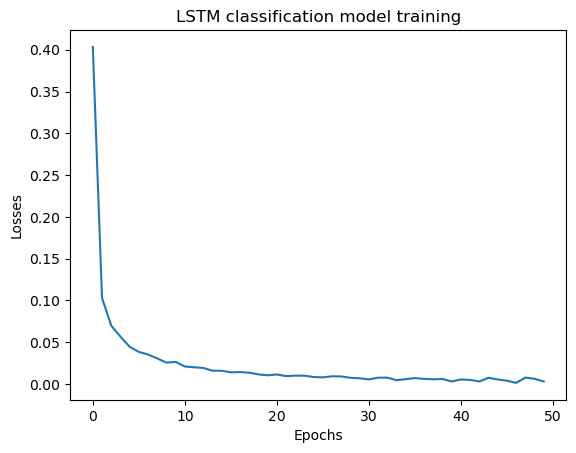

In [63]:
plt.plot(range(max_epoch), arraylosses)
plt.title("LSTM classification model training")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

In [64]:
lstm_class_model.eval()

LSTM(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [65]:
# 为 mnist 数据创建一个数据加载器实例
# 将批量大小设为 1，这将用于创建我们的Siamese神经网络训练数据集
siamese_training_set = torch.utils.data.DataLoader(ds_train, batch_size=1)  

In [66]:
# 图像数组可存储 60000 个图像
first_image_array = []  
# 标签数组，用于存储相应的图像标签
first_label_array = []  

for batch, (image, label) in enumerate(siamese_training_set):
    first_image_array.append(image)
    first_label_array.append(label)


In [67]:
import random

tempimagearray = first_image_array
templabelarray = first_label_array
# 声明 2 组包含图像以及标签的数组
firstsetimagearray = []
firstsetlabelarray = []    
secondsetimagearray = []    
secondsetlabelarray = []

# 创建一个标识数组
flagarray = []
flag = 0

# 创建的数组大小为 30000
for i in range(30000): 
    # 从下 30000 个数组中随机生成一个数组位置
    num = random.randint(30000, 59999) 
    if first_label_array[i] == templabelarray[num]:
        # 评估随机生成的图像标签是否相似
        flag = 0        
    else: flag = 1
    # 将标识转换为张量进行处理
    flag = torch.tensor(flag, dtype=torch.float32).to(device) 
    firstsetimagearray.append(first_image_array[i])
    firstsetlabelarray.append(first_label_array[i])
    secondsetimagearray.append(tempimagearray[num])
    secondsetlabelarray.append(templabelarray[num])
    flagarray.append(flag)

In [68]:
a = np.array(firstsetlabelarray)
b = np.array(firstsetimagearray)
# 使用NumPy数组将标签与相应图像堆叠在一起
c = np.array(secondsetlabelarray)   
# 创建一个二维数组
d = np.array(secondsetimagearray)   
firstsetarray = np.stack((a, b), axis=1)
secondsetarray = np.stack((c, d), axis=1)

/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_78947/1201670612.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.array(firstsetlabelarray)
/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_78947/1201670612.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(firstsetlabelarray)
/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn

In [69]:
class Siamese_Training_Dataset(torch.utils.data.Dataset):
    # 现在我们将创建Siamese训练数据集类
    def __init__(self, firstsetarray, secondsetarray, flagarray):              
        self.dataset_size = len(firstsetarray)
        self.firstsetarray = firstsetarray
        self.secondsetarray = secondsetarray
        self.flagarray = flagarray

    def __len__(self):
        # 返回数组的大小，即3000
        return self.dataset_size 
        
    def __getitem__(self, index):
        image1 = self.firstsetarray[index][1]
        # 调整图像尺寸，以防万一
        image1 = image1.reshape(1, 28, 28)          
        label1 = self.firstsetarray[index][0]
        image2 = self.secondsetarray[index][1]
        image2 = image2.reshape(1, 28, 28)
        label2 = self.secondsetarray[index][0]
        flag = flagarray[index]
        return(image1, label1, image2, label2, flag)

In [70]:
# 创建数据集实例并用数组初始化
ds_siamese = Siamese_Training_Dataset(firstsetarray, secondsetarray, flagarray)  

In [71]:
# 从数据集创建数据加载器
siamese_dataloader = torch.utils.data.DataLoader(ds_siamese, batch_size=50, shuffle=True)  

In [72]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        # pre 3.3 语法
        super(ContrastiveLoss, self).__init__()
        # 边距或半径，这是一个可以定义的参数，定义为 2.0
        self.margin = margin  

    def forward(self, out1, out2, flag):                
        # flag = 0 意味着 out1 和 out2 应该是相同的
        # flag = 1 意味着 out1 和 out2 应该是不同的
        
        # 如前所述，计算2个输出向量之间的欧氏距离
        euclidean_distance = torch.nn.functional.pairwise_distance(out1, out2)  

        # 您可以选择按照 LeCun 的精确公式，乘以 1/2 损失值将减少一半                                        
        loss = torch.mean((1-flag) * torch.pow(euclidean_distance, 2) +
        (flag) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) 
        
        return loss

In [73]:
class LSTM_Siamese_network(nn.Module):
    '''
    `input_len` 指的是 MNIST 图像的尺寸，在本例中为 28, 因为每幅图像的尺寸为 28 x 28
    '''
    def __init__(self, input_len, hidden_size, num_classes, n_layers):
        super(LSTM_Siamese_network, self).__init__()
        self.hidden_size = hidden_size 
        self.n_layers = n_layers
        
        # 层数可使模型捕捉到不同层次的抽象概念
        self.lstm = nn.LSTM(input_len, hidden_size, n_layers, batch_first=True) 
        # 最后通过线性层输出
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def feed(self, X):
        # 动态生成隐藏状态和细胞状态
        batch_size = X.size(0)
        hidden_states = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)
        cell_states = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(X.device)
        
        # 通过forward方法传入数据和动态生成的隐藏状态和细胞状态
        output, (hide, cell) = self.lstm(X, (hidden_states, cell_states))
        output = self.output_layer(output[:, -1, :])
        return output
    
    # 这里的 LSTM Siamese Model与分类模型不同, 它被转入2个LSTM网络，并返回2个输出结果
    def forward(self, x1, x2):    
        out1 = self.feed(x1)        
        out2 = self.feed(x2)        
        return out1, out2



In [76]:
lstm_siamese_train = LSTM_Siamese_network(28, 128, 10, 3)
lstm_siamese_train.to(device)

LSTM_Siamese_network(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [80]:
np.random.seed(1)  #random seeding
torch.manual_seed(1)
print("\nLoading 30000 item training dataset")
print("\nCreating LSTM Siamese network")
print(lstm_siamese_train)

# 创建损失值数组
arraylosses2 = []  

# 用于调整权重的交叉熵损失
loss_fn2 = ContrastiveLoss(2.0)
loss_fn2.to(device)

# 这里使用Adam优化器，当然还有其他选项
# 带或不带动量的梯度下降算法
opt2= torch.optim.Adam(lstm_siamese_train.parameters(), lr=learning_rate)  

print("loss = Contrastive Loss")
print("optimizer = Adam")
print("maximum epochs = %3d " % max_epoch)
print("learning rate = %0.3f " % learning_rate)
print("\nStarting training")
lstm_siamese_train.train()


for epoch in range(0, max_epoch):
    printlog('Epoch {0} / {1}'.format(epoch+1, max_epoch))
    con_loss = 0
    loop = tqdm(enumerate(siamese_dataloader), total=len(siamese_dataloader), ncols=100) 
    for i, batch in loop:
        feature1, label1, feature2, label2, flag = batch

        feature1 = feature1.reshape(-1, 28, 28).to(device)
        feature2 = feature2.reshape(-1, 28, 28).to(device)
        label1 = label1.to(device)
        label2 = label2.to(device)

        preds1, preds2 = lstm_siamese_train(feature1, feature2)
        loss = loss_fn2(preds1, preds2, flag)

        # 损失求和
        con_loss += loss.item()
        opt2.zero_grad()
        loss.backward()
        opt2.step()

        # 由于样本总数为 30000，批次总数 = 30000 / 50 = 600
        if (i + 1) % 600 == 0: 
            # 使用数组来存储损失，以便绘制损失与时间的关系图
            arraylosses2.append(con_loss / 600) 
            print(
                "Epoch...{}".format(epoch + 1),
                "Contrastive loss...{}".format(con_loss / 600),
            )
print("Done ")


Loading 30000 item training dataset

Creating LSTM Siamese network
LSTM_Siamese_network(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
loss = Contrastive Loss
optimizer = Adam
maximum epochs =  50 
learning rate = 0.001 

Starting training
2023-12-26 23:14:33
Epoch 1 / 50



  0%|                                                                       | 0/600 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.18it/s]


Epoch...1 Contrastive loss...0.27657042890166245
2023-12-26 23:14:51
Epoch 2 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.01it/s]


Epoch...2 Contrastive loss...0.15808886252343654
2023-12-26 23:15:08
Epoch 3 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.24it/s]


Epoch...3 Contrastive loss...0.10161651302206641
2023-12-26 23:15:26
Epoch 4 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.42it/s]


Epoch...4 Contrastive loss...0.0751670205387442
2023-12-26 23:15:43
Epoch 5 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.33it/s]


Epoch...5 Contrastive loss...0.059994866779989026
2023-12-26 23:16:00
Epoch 6 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.20it/s]


Epoch...6 Contrastive loss...0.047004175094916716
2023-12-26 23:16:18
Epoch 7 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.27it/s]


Epoch...7 Contrastive loss...0.042022492290410204
2023-12-26 23:16:36
Epoch 8 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.52it/s]


Epoch...8 Contrastive loss...0.04049936957269286
2023-12-26 23:16:55
Epoch 9 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.88it/s]


Epoch...9 Contrastive loss...0.03039470607965389
2023-12-26 23:17:14
Epoch 10 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 31.85it/s]


Epoch...10 Contrastive loss...0.023970488077648042
2023-12-26 23:17:33
Epoch 11 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 31.79it/s]


Epoch...11 Contrastive loss...0.02591616656062494
2023-12-26 23:17:52
Epoch 12 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.54it/s]


Epoch...12 Contrastive loss...0.022943078416016456
2023-12-26 23:18:11
Epoch 13 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.87it/s]


Epoch...13 Contrastive loss...0.022862786617473225
2023-12-26 23:18:29
Epoch 14 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.47it/s]


Epoch...14 Contrastive loss...0.02101527919649622
2023-12-26 23:18:47
Epoch 15 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.61it/s]


Epoch...15 Contrastive loss...0.021925089223235165
2023-12-26 23:19:05
Epoch 16 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.22it/s]


Epoch...16 Contrastive loss...0.01554769723232918
2023-12-26 23:19:23
Epoch 17 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.25it/s]


Epoch...17 Contrastive loss...0.010143528786405417
2023-12-26 23:19:42
Epoch 18 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 35.26it/s]


Epoch...18 Contrastive loss...0.01543819851165002
2023-12-26 23:19:59
Epoch 19 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.93it/s]


Epoch...19 Contrastive loss...0.01507763192109754
2023-12-26 23:20:17
Epoch 20 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.74it/s]


Epoch...20 Contrastive loss...0.009260869467896858
2023-12-26 23:20:37
Epoch 21 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.96it/s]


Epoch...21 Contrastive loss...0.01279381834598098
2023-12-26 23:20:55
Epoch 22 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.92it/s]


Epoch...22 Contrastive loss...0.011751030396996308
2023-12-26 23:21:15
Epoch 23 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.92it/s]


Epoch...23 Contrastive loss...0.012669613334250016
2023-12-26 23:21:35
Epoch 24 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.30it/s]


Epoch...24 Contrastive loss...0.010719227937726146
2023-12-26 23:21:55
Epoch 25 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.59it/s]


Epoch...25 Contrastive loss...0.009111428927787225
2023-12-26 23:22:14
Epoch 26 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.79it/s]


Epoch...26 Contrastive loss...0.010456110375034768
2023-12-26 23:22:35
Epoch 27 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.74it/s]


Epoch...27 Contrastive loss...0.007761787197856999
2023-12-26 23:22:52
Epoch 28 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:20<00:00, 29.43it/s]


Epoch...28 Contrastive loss...0.01262195240325648
2023-12-26 23:23:13
Epoch 29 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.53it/s]


Epoch...29 Contrastive loss...0.010063982238164139
2023-12-26 23:23:31
Epoch 30 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.50it/s]


Epoch...30 Contrastive loss...0.006675530878725719
2023-12-26 23:23:48
Epoch 31 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.50it/s]


Epoch...31 Contrastive loss...0.009639265340967616
2023-12-26 23:24:07
Epoch 32 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 31.22it/s]


Epoch...32 Contrastive loss...0.0062051033292308
2023-12-26 23:24:26
Epoch 33 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.61it/s]


Epoch...33 Contrastive loss...0.006065331799639656
2023-12-26 23:24:44
Epoch 34 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 35.07it/s]


Epoch...34 Contrastive loss...0.005136878936349755
2023-12-26 23:25:01
Epoch 35 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.54it/s]


Epoch...35 Contrastive loss...0.006316626926010637
2023-12-26 23:25:18
Epoch 36 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.38it/s]


Epoch...36 Contrastive loss...0.006825536995540157
2023-12-26 23:25:36
Epoch 37 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.81it/s]


Epoch...37 Contrastive loss...0.005588032004437764
2023-12-26 23:25:54
Epoch 38 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.27it/s]


Epoch...38 Contrastive loss...0.005856601306691876
2023-12-26 23:26:13
Epoch 39 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:15<00:00, 37.84it/s]


Epoch...39 Contrastive loss...0.007622397251359416
2023-12-26 23:26:28
Epoch 40 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.52it/s]


Epoch...40 Contrastive loss...0.0050722520451093565
2023-12-26 23:26:46
Epoch 41 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.28it/s]


Epoch...41 Contrastive loss...0.005124777764811673
2023-12-26 23:27:04
Epoch 42 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.10it/s]


Epoch...42 Contrastive loss...0.007879210524883778
2023-12-26 23:27:22
Epoch 43 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 36.02it/s]


Epoch...43 Contrastive loss...0.008265791867601516
2023-12-26 23:27:39
Epoch 44 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 34.22it/s]


Epoch...44 Contrastive loss...0.007364776968782205
2023-12-26 23:27:56
Epoch 45 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.44it/s]


Epoch...45 Contrastive loss...0.005981523557231109
2023-12-26 23:28:14
Epoch 46 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.04it/s]


Epoch...46 Contrastive loss...0.005687114001480988
2023-12-26 23:28:33
Epoch 47 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:16<00:00, 35.40it/s]


Epoch...47 Contrastive loss...0.005221049467064442
2023-12-26 23:28:50
Epoch 48 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.20it/s]


Epoch...48 Contrastive loss...0.0035327216527942557
2023-12-26 23:29:08
Epoch 49 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.93it/s]


Epoch...49 Contrastive loss...0.0034644032775918276
2023-12-26 23:29:26
Epoch 50 / 50



100%|█████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.04it/s]

Epoch...50 Contrastive loss...0.004726815089738921
Done 


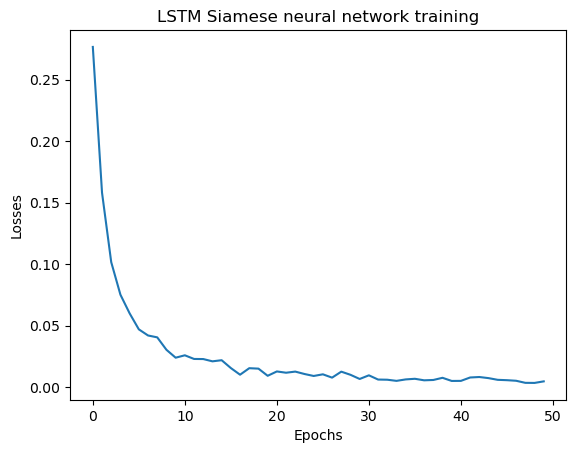

In [81]:
plt.plot(range(max_epoch), arraylosses2)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM Siamese neural network training")
plt.show()

In [82]:
lstm_siamese_train.eval()

LSTM_Siamese_network(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [89]:
# 创建数据加载器，以创建存储测试的数组
mnist_siamese_set = torch.utils.data.DataLoader(ds_val, batch_size=1, shuffle=False) 

In [108]:
# 包含所有测试图像的数组
masterimagearray = [] 
masterimagelabels = []

# 创建可访问的 0 至 9 数组, 通过LSTM Siamese Network进行评估
testzeros = []
testones = []
testtwos = []    
testthrees = []  
testfours = []
testfives = []
testsixes = []
testsevens = []
testeights = []
testnines = []

for batch, (images, labels) in enumerate(mnist_siamese_set):
    images = images.to(device)
    labels = labels.to(device)
    masterimagearray.append(images)
    masterimagelabels.append(labels)

    if labels == 0:
        testzeros.append(images)
    elif labels == 1:
        testones.append(images)
    elif labels == 2:
        testtwos.append(images)
    elif labels == 3:
        testthrees.append(images)
    elif labels == 4:
        testfours.append(images)
    elif labels == 5:
        testfives.append(images)
    elif labels == 6:
        testsixes.append(images)
    elif labels == 7:
        testsevens.append(images)
    elif labels == 8:
        testeights.append(images)
    else:
        testnines.append(images)

In [109]:
arrayoftestnumbers = [testzeros, testones, testtwos, testthrees, testfours, testfives, testsixes, testsevens, testeights, testnines]

In [110]:
def EvaluateSiamese(image):
    sumdist = []
    resultsarray = []
    euclid_distance = None
    for i in range(len(arrayoftestnumbers)):
        num = 0
        for ii in range(10):
            # 生成随机数的方式不会生成相同的随机数
            num = random.randint(num, num + 80)
            with torch.no_grad():
                out1, out2 = lstm_siamese_train(image.view(-1, 28, 28), arrayoftestnumbers[i][num].view(-1, 28, 28))
                # 计算欧几里得距离
                dist = torch.nn.functional.pairwise_distance(out1, out2) 
            # 追加到数组
            sumdist.append(dist)
        # 欧几里得距离平均值
        result = sum(sumdist) / 10 
        sumdist = []
        resultsarray.append(result)

    correctanswer = None

    for i in range(10):
        # 正确答案是欧氏距离小于1.0的答案
        if resultsarray[i] < 1.0: 
            correctanswer = i
            euclid_distance = resultsarray[i]
    # 用欧几里得距离返回正确答案
    return correctanswer, euclid_distance #returns the correct answer with euclidean distance

In [111]:
# 创建测试集
mnist_test_set = torch.utils.data.DataLoader(ds_val, batch_size=50, shuffle=False)

In [112]:
test_image_batch = None
test_image_label = None
# 从测试集中选择一个随机图像集来测试分类模型
for batch, (image, label) in enumerate(mnist_test_set):  
    # 测试集包括 10000 个样本，分成 200 批，每批 50 个图像
    if batch == 51: 
        test_image_batch = image.to(device)
        test_image_label = label.to(device)
        break

In [113]:
with torch.no_grad():
    # 使用视图功能将图像重塑为 50、28、28
    output = lstm_class_model(test_image_batch.view(-1, 28, 28)) 

In [114]:
predicted = torch.max(output, 1)[1]

In [140]:
positions = []

for i in range(50):
    # 获得数组中的位置
    if predicted[i] != test_image_label[i]:
       # 图像被错误分类
       positions.append(i)

In [116]:
positions

[47]

In [138]:
predicted[47]

tensor(3, device='mps:0')

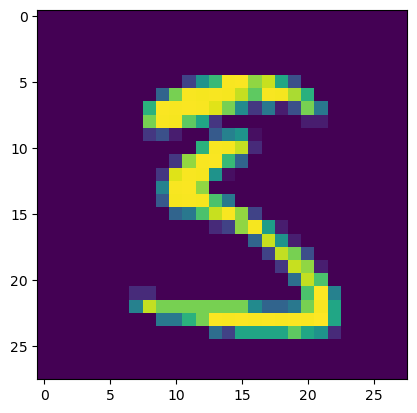

In [135]:
# 将张量移动到CPU并转换为NumPy数组
image_for_plot = masterimagearray[2597].cpu().detach().numpy()

# 去除单通道的维度
image_data = image_for_plot.squeeze()

# 显示图像
plt.imshow(image_data)
plt.draw()
plt.show()

In [125]:
answer, dist = EvaluateSiamese(masterimagearray[3462])

if answer == masterimagelabels[3462]:
    print("Answer is " + str(answer) + " and correct " + " distance is " + str(dist))
# 有时，Siamese Model无法预测，如果答案为None，将输出 "Don't know answer"。
elif answer is None:
    print("Don't know answer")
else: print("Wrong answer, given answer is " + str(answer) + " but answer is " + str(masterimagelabels[3462]))

Answer is 5 and correct  distance is tensor([0.2242], device='mps:0')


In [120]:
answer, dist = EvaluateSiamese(masterimagearray[3762])

if answer == masterimagelabels[3762]:
    print("Answer is " + str(answer) + " and correct " + " distance is " + str(dist))
elif answer is None:
    print("Don't know answer")
else: print("Wrong answer, given answer is " + str(answer) + " but answer is " + str(masterimagelabels[3762]))

Answer is 6 and correct  distance is tensor([0.5165], device='mps:0')


In [121]:
answer, dist = EvaluateSiamese(masterimagearray[3767])

if answer == masterimagelabels[3767]:
   print("Answer is " + str(answer) + " and correct " + " distance is " + str(dist))
elif answer is None:
   print("Don't know answer")
else: print("Wrong answer, given answer is " + str(answer) + " but answer is " + str(masterimagelabels[3767]))

Answer is 7 and correct  distance is tensor([0.6107], device='mps:0')


In [122]:
answer, dist = EvaluateSiamese(masterimagearray[3941])

if answer == masterimagelabels[3941]:
   print("Answer is " + str(answer) + " and correct " + " distance is " + str(dist))
elif answer is None:
    print("Don't know answer")
else: print("Wrong answer, given answer is " + str(answer) + " but answer is " + str(masterimagelabels[3941]))

Answer is 4 and correct  distance is tensor([0.6454], device='mps:0')
